In [3]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import importlib
import tensorflow as tf
import tensorflow.keras as K
import math, datetime, pandas as pd, numpy as np
import matplotlib.pyplot as plt,random, pickle, glob, os
import sklearn
from PIL import Image
import tarfile
import cv2
import random

## Loading data

Download and extract training data by uncommenting below cell

In [158]:
# !wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
# fname='imagenet-sample-train.tar.gz'
# if (fname.endswith("tar.gz")):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [5]:
input_size=64

In [6]:
path='train/'

img_list = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(img_list); n

19439

In [7]:
train_list=random.sample(img_list,2000)
len(train_list)

2000

In [8]:
# val_list=list(set(img_list)-set(train_list))
# val_list=random.sample(val_list,300)
# len(val_list)

In [11]:
val_list = glob.glob('set5/*.*', recursive=True)
len(val_list)

5

In [12]:
def read_image(img_path):
    global input_size
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lr = cv2.resize(img, (input_size,input_size),interpolation=cv2.INTER_CUBIC)
    img_hr = cv2.resize(img, (input_size*4,input_size*4),interpolation=cv2.INTER_CUBIC)
    return img_lr,img_hr


(256, 256, 3)


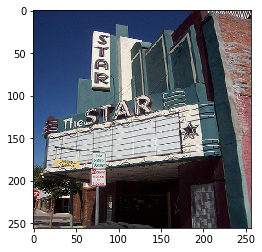

In [13]:
_,img=read_image(img_list[3])
print(img.shape)
plt.imshow(img)

(256, 256, 3)


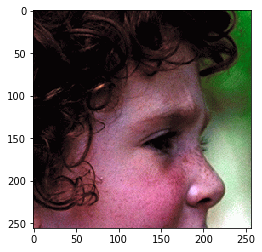

In [14]:
_,img=read_image(val_list[0])
print(img.shape)
plt.imshow(img)

## Super Resolution Model

In [15]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [16]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [17]:
def deconv_block(x, filters,size, shape, stride=(1,1)):
    x = K.layers.Convolution2DTranspose(filters, size, size, strides=stride, 
       padding='same', output_shape=(None,)+shape)(x)
    return K.layers.Activation('relu')(x)

In [18]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [122]:
def get_srmodel():
    inp=K.Input(shape=(None,None,3))

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(4): x=res_block(x,16)

    x=up_block(x,nf=32)
    for i in range(2): x=res_block(x,32)

    x=up_block(x,nf=64)
    for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(16,(3,3),padding='same',activation='relu')(x)
    outp= K.layers.Conv2D(3,(3,3),activation='sigmoid',padding='same',name='output_layer')(x)
    return inp,outp

In [123]:
inp,outp=get_srmodel()
sr_model=K.Model(inp,outp)
sr_model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_14 (InputLayer)               (None, None, None, 3)   0                                                 
______________________________________________________________________________________________________________
conv2d_132 (Conv2D)                 (None, None, None, 16)  448          input_14[0][0]                       
______________________________________________________________________________________________________________
activation_270 (Activation)         (None, None, None, 16)  0            conv2d_132[0][0]                     
______________________________________________________________________________________________________________
conv2d_133 (Conv2D)                 (None, None, None, 16)  2320         activation_270[0][0]                 
_

### loading vgg for calculating perceptual loss from one of its layer

In [124]:
vgg_inp=K.Input(shape=outp.shape[1:])
vgg= K.applications.VGG16(include_top=False, 
                                  input_tensor=vgg_inp)

In [125]:
for l in vgg.layers: l.trainable=False

In [126]:
# preproc_layer = K.layers.Lambda(preproc)

In [127]:
#Here we are using vgg layer at index 36 to be the layer to calculate loss between Traget and predicted image
vgg_out_layer = vgg.get_layer(index=5).output

# making model Model(inputs, outputs)
vgg_content = K.Model(vgg_inp, vgg_out_layer)

vgg_content.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_15 (InputLayer)                            (None, None, None, 3)                       0                
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)                      1792             
______________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (None, None, None, 64)                      36928            
______________________________________________________________________________________________________________
block1_pool (MaxPooling2D)                       (None, None, None, 64)                      0                
_

## Data Generator and Metrics

In [128]:
def randomHorizontalFlip(img1,img2, u=0.5):
    if np.random.random() < u:
        img1 = cv2.flip(img1, 1)
        img2 = cv2.flip(img2, 1)
    return img1,img2

In [129]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*4, input_size*4),interpolation=cv2.INTER_CUBIC)
                img1,img2 = randomHorizontalFlip(img1,img2)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*4, input_size*4),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [130]:
# l=next(valid_generator())
# plt.imshow(l[1][0])

In [131]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [132]:
# This is our perceptual loss function
def perceptual_loss(y_true,y_pred):
    y_t=vgg_content(y_true)
    y_p=vgg_content(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

In [133]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
sr_model.compile(optimizer=adam,loss=perceptual_loss,metrics=[psnr,ssim])

In [135]:
batch_size=16
input_size=72

In [136]:
def fit(model,epoch=2):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [137]:
sr_model=fit(sr_model,10)

Epoch 1/10
125/125 [==============================] - 132s 1s/step - loss: 9.8802 - psnr: 16.7749 - ssim: 0.4855 - val_loss: 6.0682 - val_psnr: 19.3037 - val_ssim: 0.6014
Epoch 2/10
125/125 [==============================] - 124s 992ms/step - loss: 8.5695 - psnr: 19.0060 - ssim: 0.5276 - val_loss: 5.4541 - val_psnr: 20.7697 - val_ssim: 0.6232
Epoch 3/10
125/125 [==============================] - 124s 993ms/step - loss: 8.3138 - psnr: 19.4238 - ssim: 0.5359 - val_loss: 5.0865 - val_psnr: 20.5638 - val_ssim: 0.6363
Epoch 4/10
125/125 [==============================] - 124s 993ms/step - loss: 8.1494 - psnr: 19.6720 - ssim: 0.5412 - val_loss: 4.9377 - val_psnr: 19.6284 - val_ssim: 0.6551
Epoch 5/10
125/125 [==============================] - 124s 993ms/step - loss: 8.0441 - psnr: 19.7307 - ssim: 0.5441 - val_loss: 4.9351 - val_psnr: 19.5691 - val_ssim: 0.6541
Epoch 6/10
125/125 [==============================] - 124s 993ms/step - loss: 7.9704 - psnr: 19.8390 - ssim: 0.5467 - val_loss: 4.909

In [142]:
sr_model=fit(sr_model,15)

Epoch 1/15
125/125 [==============================] - 124s 992ms/step - loss: 7.7305 - psnr: 20.2700 - ssim: 0.5529 - val_loss: 4.5860 - val_psnr: 20.2032 - val_ssim: 0.6593
Epoch 2/15
125/125 [==============================] - 124s 992ms/step - loss: 7.6958 - psnr: 20.3233 - ssim: 0.5532 - val_loss: 4.5298 - val_psnr: 20.3288 - val_ssim: 0.6627
Epoch 3/15
125/125 [==============================] - 124s 993ms/step - loss: 7.6606 - psnr: 20.3666 - ssim: 0.5533 - val_loss: 4.5578 - val_psnr: 19.9366 - val_ssim: 0.6602
Epoch 4/15
125/125 [==============================] - 124s 993ms/step - loss: 7.6398 - psnr: 20.3480 - ssim: 0.5527 - val_loss: 4.4746 - val_psnr: 20.0767 - val_ssim: 0.6648
Epoch 5/15
125/125 [==============================] - 124s 993ms/step - loss: 7.6191 - psnr: 20.3271 - ssim: 0.5525 - val_loss: 4.4368 - val_psnr: 20.1292 - val_ssim: 0.6631
Epoch 6/15
125/125 [==============================] - 124s 993ms/step - loss: 7.5977 - psnr: 20.3923 - ssim: 0.5531 - val_loss: 4.

In [152]:
sr_model=fit(sr_model,15)

Epoch 1/15
125/125 [==============================] - 124s 992ms/step - loss: 7.4358 - psnr: 20.5360 - ssim: 0.5547 - val_loss: 4.1994 - val_psnr: 20.8111 - val_ssim: 0.6794
Epoch 2/15
125/125 [==============================] - 124s 993ms/step - loss: 7.4205 - psnr: 20.5481 - ssim: 0.5545 - val_loss: 4.2073 - val_psnr: 20.4074 - val_ssim: 0.6755
Epoch 3/15
125/125 [==============================] - 124s 993ms/step - loss: 7.4164 - psnr: 20.5049 - ssim: 0.5543 - val_loss: 4.1802 - val_psnr: 20.6912 - val_ssim: 0.6809
Epoch 4/15
125/125 [==============================] - 124s 993ms/step - loss: 7.4000 - psnr: 20.5482 - ssim: 0.5549 - val_loss: 4.1530 - val_psnr: 20.3925 - val_ssim: 0.6832
Epoch 5/15
125/125 [==============================] - 124s 993ms/step - loss: 7.3971 - psnr: 20.5150 - ssim: 0.5549 - val_loss: 4.1633 - val_psnr: 20.8615 - val_ssim: 0.6777
Epoch 6/15
125/125 [==============================] - 124s 993ms/step - loss: 7.3883 - psnr: 20.5971 - ssim: 0.5551 - val_loss: 4.

In [153]:
tlr,hlr=read_image(val_list[2])
tlr=np.expand_dims(tlr,axis=0)
pred=sr_model.predict(tlr/255.)

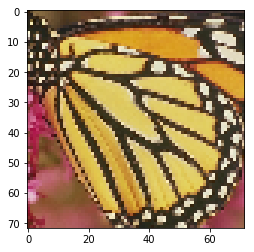

In [154]:
plt.imshow(tlr[0]/255.)

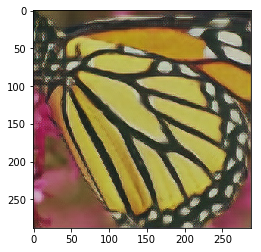

In [155]:
plt.imshow(pred[0])

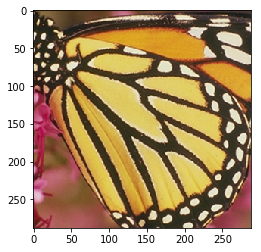

In [156]:
plt.imshow(hlr/255.)

In [157]:
K.models.save_model(sr_model,'sr_final.h5',include_optimizer=False)